In [1]:
## importing packages
import torch
import os
import sys
import joypy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm

## exposing path 
sys.path.insert(0, "../")

from int_filt.experiments import create_experiment
from int_filt.utils.config import configuration
from int_filt.utils.utils import ensure_reproducibility, move_batch_to_device

In [2]:
## globals
ACTIVATIONS = {
    "relu": torch.nn.ReLU()
}

OPTIMIZERS = {
    "adam": torch.optim.Adam,
    "adam-w": torch.optim.AdamW
}

SCHEDULERS = {
    "none": None,
    "cosine_annealing": torch.optim.lr_scheduler.CosineAnnealingLR
}

DEVICES = {
    "cpu": torch.device("cpu"),
    "cuda": torch.device("cuda")
}

## defining simulation settings
non_linearity = "exp"
num_dims = 1
num_sims = 1_000
num_iters = 1_000_000
step_size = 1e-2
sigma_x = 1e-2
sigma_y = 1e-2
beta = 1e-0

## defining plotting settings
num_observations_to_plot = 1_000
num_iters_to_plot = 200

## defining model settings
b_net_amortized = False
b_net_lr = 1e-3
b_net_num_grad_steps = 100

## defining sampling settings
num_samples = 500
num_time_steps = 300

## defining mc estimation settings
num_mc_samples = 500

## defining optimizer and scheduler settings
scheduler = "cosine_annealing"
optimizer = "adam-w"

## defining preprocessing settings
preprocessing = "sim"

## defining hiden dimensions
hidden_widths = [500]*5

## defining interpolant settings
epsilon = 2e-2

Exponential non linearity

In [3]:
## defining configurations
experiment_config = {
    "experiment": "nlg",
    "non_linearity": non_linearity,
    "num_dims": num_dims,
    "num_sims": num_sims,
    "num_iters": num_iters,
    "step_size": step_size,
    "sigma_x": sigma_x,
    "sigma_y": sigma_y,
    "beta": beta,
    "b_net_amortized": b_net_amortized,
    "b_net_lr": b_net_lr,
    "b_net_num_grad_steps": b_net_num_grad_steps,
    "b_net_scheduler": scheduler,
    "b_net_optimizer": optimizer,
    "b_net_hidden_dims": hidden_widths,
    "num_samples": num_mc_samples,
    "preprocessing": preprocessing,
    "epsilon": epsilon
}
## parsing default arguments
args = configuration(args=[])
## retrieving activations
args.b_net_activation = ACTIVATIONS[args.b_net_activation]
## retrieving device
args.device = DEVICES[args.device]
## creating experiment
args = vars(args)

## setting current configurations
for k, v in experiment_config.items():
    args[k] = v

## adding mc configuration
args["mc_config"] = {"num_samples": args["num_samples"]}

## prepare for training drift
b_net_num_grad_step = args["b_net_num_grad_steps"]
b_net_optimizer = args["b_net_optimizer"]
b_net_scheduler = args["b_net_scheduler"]
b_net_lr = args["b_net_lr"]

## dump dir 
dump_dir = args["dump_dir"]
path = Path(dump_dir)
path.mkdir(parents=True, exist_ok=True)

## reproducibility
random_seed = args["random_seed"]
ensure_reproducibility(random_seed)

## displaying current arguments
print(args)

## creating experiment
experiment = create_experiment(args)

{'interpolant_method': 'pffp_v0', 'epsilon': 0.02, 'num_samples': 500, 'backbone': 'mlp', 'b_net_hidden_dims': [500, 500, 500, 500, 500], 'b_net_activation': ReLU(), 'b_net_activate_final': False, 'b_net_amortized': False, 'experiment': 'nlg', 'sigma_x': 0.01, 'sigma_y': 0.01, 'beta': 1.0, 'num_dims': 1, 'num_sims': 1000, 'num_iters': 1000000, 'non_linearity': 'exp', 'step_size': 0.01, 'log_dir': './out/2024-06-16/run_2024-06-16_13-25-17', 'dump_dir': 'exp/2024-06-16/run_2024-06-16_13-25-17', 'b_net_num_grad_steps': 100, 'b_net_optimizer': 'adam-w', 'b_net_scheduler': 'cosine_annealing', 'b_net_lr': 0.001, 'random_seed': 128, 'device': device(type='cuda'), 'preprocessing': 'sim', 'mc_config': {'num_samples': 500}}


100%|██████████| 999999/999999 [00:26<00:00, 37603.14it/s]


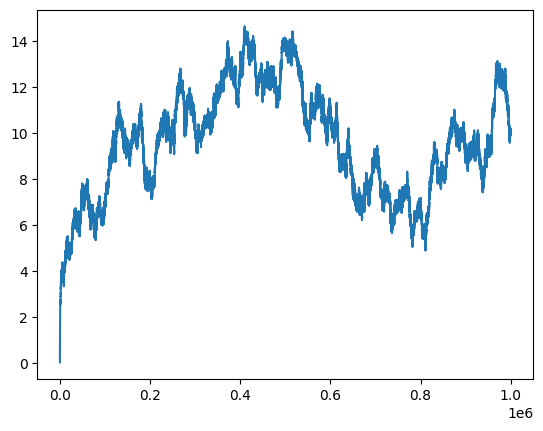

In [4]:
PLOT_SIMULATION = True
if PLOT_SIMULATION:
    ## plotting
    ## retrieving data
    latent_states_nlg_exp = torch.squeeze(experiment.ssm.sim["latent_states"]).numpy().T
    observations_nlg_exp = torch.squeeze(experiment.ssm.sim["latent_states"]).numpy().T
    ## constructing data frame
    observation_indices = np.arange(args["num_iters"])
    observation_indices = np.arange(num_iters_to_plot)
    latent_states_nlg_exp = pd.DataFrame(latent_states_nlg_exp[:num_observations_to_plot, :num_iters_to_plot], columns = observation_indices)
    ## ridge plot
    #fig, axes = joypy.joyplot(latent_states_nlg_exp, ylabels=False)
    plt.plot(experiment.ssm.sim["latent_states"][:, 0, 0])
    #plt.plot(experiment.ssm.sim["observations"][:, 0, 0])

In [5]:
batch = experiment.get_batch()
print("BEFORE STANDARDIZATION\n")
for k, v in batch.items():
    print(k, "-> mean: ", v.mean(), ", std: ", v.std(), "shape: ", v.shape)
batch = experiment.preprocessing(batch)
print("\nAFTER PREPROCESSING\n")
for k, v in batch.items():
    print(k, "-> mean: ", v.mean(), ", std: ", v.std(), "shape: ", v.shape)

BEFORE STANDARDIZATION

x0 -> mean:  tensor(10.7111) , std:  tensor(4.8314) shape:  torch.Size([1000, 1])
x1 -> mean:  tensor(10.7112) , std:  tensor(4.8312) shape:  torch.Size([1000, 1])
xc -> mean:  tensor(10.7111) , std:  tensor(4.8314) shape:  torch.Size([1000, 1])
y -> mean:  tensor(10.7114) , std:  tensor(4.8312) shape:  torch.Size([1000, 1])

AFTER PREPROCESSING

x0 -> mean:  tensor(-0.0157) , std:  tensor(1.0017) shape:  torch.Size([1000, 1])
x1 -> mean:  tensor(-0.0156) , std:  tensor(1.0018) shape:  torch.Size([1000, 1])
xc -> mean:  tensor(-0.0157) , std:  tensor(1.0017) shape:  torch.Size([1000, 1])
y -> mean:  tensor(-0.0155) , std:  tensor(1.0020) shape:  torch.Size([1000, 1])


100%|██████████| 300/300 [00:00<00:00, 11395.91it/s]

gt_dist.shape=torch.Size([300]), torch.Size([300])
gt_dist.mean()=tensor(7.1694), predicted_dist.mean()=tensor(7.1688)
gt_dist.std()=tensor(0.0098), predicted_dist.std()=tensor(0.0114)
x0=7.168546199798584


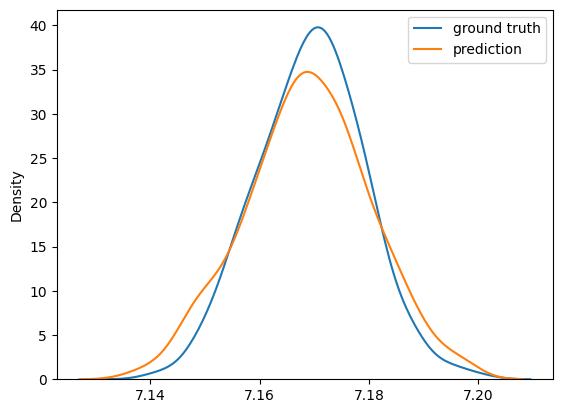

In [6]:
## constructing sampling config dictionary
sample_config = {
    "num_time_steps": num_time_steps,
    "num_samples": num_samples
}

## getting sample batch
batch = experiment.get_batch()
batch = move_batch_to_device(batch, experiment.device)

## sampling from model
samples = experiment.sample(batch, sample_config = sample_config)

## sampling from gt state transition
x = batch["x0"]
samples_gt = torch.zeros_like(samples)
for sample_id in tqdm(range(num_samples)):
    x1 = experiment.ssm.state_transition(x)
    samples_gt[sample_id] = x1
## plotting example histogram
observation_idx = 100
gt_dist = samples_gt[:, observation_idx, 0]
predicted_dist = samples[:, observation_idx, 0]
print(f"{gt_dist.shape=}, {predicted_dist.shape}")
print(f"{gt_dist.mean()=}, {predicted_dist.mean()=}")
print(f"{gt_dist.std()=}, {predicted_dist.std()=}")
sns.kdeplot(gt_dist, label = "ground truth")
sns.kdeplot(predicted_dist, label = "prediction")
## plotting preceeding state
x = batch["x0"]
x0 = x.detach().cpu()[observation_idx, 0].item()
print(f"{x0=}")
## displaying legends
plt.legend()

In [7]:
## initializing optimizer and scheduler
b_net_optimizer = OPTIMIZERS[b_net_optimizer](experiment.b_net.backbone.parameters(), lr = b_net_lr)
b_net_scheduler = SCHEDULERS[b_net_scheduler]
if b_net_scheduler is not None:
    b_net_scheduler = b_net_scheduler(b_net_optimizer, b_net_num_grad_step)

## constructing optimization config dictionary
b_net_optim_config = {
    "num_grad_steps": b_net_num_grad_step,
    "optimizer": b_net_optimizer,
    "scheduler": b_net_scheduler
}

## training b_net 
experiment.train(b_net_optim_config)
## saving the weights
torch.save(experiment.b_net.state_dict(), os.path.join(dump_dir, "b_net_exp.pt"))

Grad Step 100/100, MSELoss: 0.3237452208995819, Learning Rate 0.0: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]                  


100%|██████████| 300/300 [00:00<00:00, 16824.10it/s]


gt_dist.shape=torch.Size([300]), torch.Size([300])
gt_dist.mean()=tensor(7.1695), predicted_dist.mean()=tensor(7.1688)
gt_dist.std()=tensor(0.0105), predicted_dist.std()=tensor(0.0117)
x0=7.168546199798584


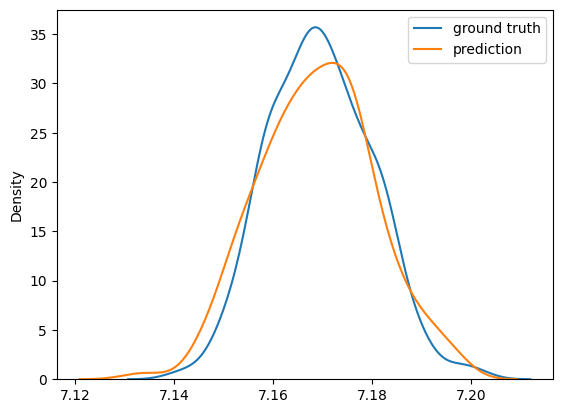

In [8]:
## sampling from model
samples = experiment.sample(batch, sample_config = sample_config)

## sampling from gt state transition
x = batch["x0"]
samples_gt = torch.zeros_like(samples)
for sample_id in tqdm(range(num_samples)):
    x1 = experiment.ssm.state_transition(x)
    samples_gt[sample_id] = x1
## plotting example histogram
observation_idx = 100
gt_dist = samples_gt[:, observation_idx, 0]
predicted_dist = samples[:, observation_idx, 0]
print(f"{gt_dist.shape=}, {predicted_dist.shape}")
print(f"{gt_dist.mean()=}, {predicted_dist.mean()=}")
print(f"{gt_dist.std()=}, {predicted_dist.std()=}")
sns.kdeplot(gt_dist, label = "ground truth")
sns.kdeplot(predicted_dist, label = "prediction")
## plotting preceeding state
x = batch["x0"]
x0 = x.detach().cpu()[observation_idx, 0].item()
print(f"{x0=}")
## displaying legends
plt.legend()